<a id='top'></a>

------

CSCI E-82 Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section 13:  
----------
2023 December 16, 11:30 AM EST

*Daniel Sauble*

------

Topics for this section
==================
- [Large Language Models (LLM)](#llm)
    - [T5](#t5)
    - [GPT](#gpt)
    - [LLaMA](#llama)
- [Text-to-image models](#text_to_image)
    - [DALL-E 2](#dalle)
    - [Stable Diffusion](#stable_diffusion)
- [Embeddings](#embeddings)
    - [text-embedding-ada-002](#ada) (Text)
    - [CLIP and OpenCLIP](#clip) (Images)
- [Vector databases](#databases)
    - [Pinecone](#pinecone)
    - [DataStax Astra](#astra)
- [Retrieval-Augmented Generation (RAG)](#rag)
- [AI agents](#agents)
------

<a id='llm'></a>

<a href='#top'>Back to top</a>

## Large Language Models (LLM)
-----

LLMs are models trained on vast amounts of textual data. The most popular architecture for this is transformers (multi-head attention). The most powerful general purpose LLMs are most easily used via an API, but you increasingly download and run smaller local models for specific tasks.

Here's [a good read](https://towardsdatascience.com/transformers-141e32e69591) on the developments leading to modern transformer models.

The main things to keep in mind when evaluating these models:

* *Context window*: The number of tokens a model can keep in its working memory. The more tokens, the more context a model can utilize. Modern models like Claude 2 or GPT-4 Turbo have context windows of up to 100K tokens. The computational complexity is generally quadratic with respect to the context window size, which makes it infeasible to have an indeterminately large context window.
* *Performance*: LLMs are generally quite expensive to train and run relative to other ML models. Most state-of-the-art models must be run in the cloud in order to generate text quickly enough during inference. You can run smaller models locally on a laptop or even smartphone, but at the cost of slower inference and more limited capabilities.
* *Multi-modality*: Traditional LLMs operate solely on text, but increasingly support images, video, and audio. This expands their usefulness to use cases like image-to-text generation or answering questions about uploaded media.

<a id='t5'></a>

<a href='#top'>Back to top</a>

### T5
-----

The T5 model is a small (60M parameters) text-to-text transformer model developed by Google. It's pre-trained on the [Colossal Clean Crawled Corpus (C4)](https://www.tensorflow.org/datasets/catalog/c4). See the full docs on [Hugging Face](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Model).

First, let's import the necessary libraries.

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration # pip install transformers

/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we can download the T5-small model (and corresponding tokenizer) from Hugging Face.

In [2]:
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5 expects you to format the prompt in a certain way based on the task you want to perform. For example, a translation task needs the prefix `translate X to Y: `.

The process is to take an input prompt, tokenize it, generate output tokens, and convert the output tokens back to a string.

In [6]:
# Input prompt
input_text = "translate English to German: You're almost done with the semester!"

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt", padding=True)

# Generate output tokens
output = model.generate(**inputs)

# Convert the output tokens to a string
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the result
print(output_text)

Sie sind fast fertig mit dem Semester!


If we pass this to Google Translate, we can verify that this is a pretty good translation.

Keep in mind that T5 is small because it's trained on a very limited set of tasks. If we try to translate English to Spanish, it won't work, and we can't even go backwards from German to English. We either need to retrain the model on the tasks we need to perform, or else use a more general purpose model like GPT or LLaMa.

<a id='gpt'></a>

<a href='#top'>Back to top</a>

### GPT
-----

GPT, which stands for Generative Pre-trained Transformer, is a series of transformer models developed by OpenAI. GPT-4 Turbo is generally considered to be the current state of the art for LLMs.

* GPT-2 (2019) has 1.5B parameters (25x more than T5-small)
* GPT-3.5 (2022) has 175B parameters (116x more than GPT-2)
* GPT-4 Turbo (2023) has a rumored 1.7T parameters (9.7x more than GPT-3.5)

These models are evaluated on a battery of tests, from AP Biology to SAT Math to the Uniform Bar Exam, in order to gauge their performance. These models are available via API which makes it easy to use them without having to download all of the weights and run inference locally.

Let's try out GPT-4. First, we need to import the openai library.

In [19]:
from openai import OpenAI # pip install openai

Now we generate an OpenAI API key from https://platform.openai.com/api-keys, define an environment variable in a `.env` file, and import our OpenAI key.

The .env file should contain a single key/value pair like this:

```
OPENAI_API_KEY=your_api_key_here
```

In [38]:
import os
from dotenv import load_dotenv # pip install python-dotenv

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key is None:
    raise ValueError("No API key found. Set the OPENAI_API_KEY environment variable.")

openai_client = OpenAI()

Now we pass the model we want (GPT-4 Turbo) and our prompt to the `openai.Completion` API.

Because this is a more general purpose model, we don't have to format our prompt in a particular way or adhere to a limited set of tasks. The OpenAI library is also taking care of tokenization for us.

In [41]:
def query_gpt4(prompt):  
  response = openai_client.chat.completions.create(
    model="gpt-4-1106-preview", # This is the id of the GPT-4 Turbo model
    messages=[
      {"role": "user", "content": prompt}
    ]
  )
  return response.choices[0].message.content

In [18]:
# Example usage
prompt = "Explain how multi-head attention works in simple terms."
print(query_gpt4(prompt))

Imagine you're at a party trying to have a conversation with a friend. There's a lot of noise around—music playing, multiple people talking, glasses clinking. To understand what your friend is saying, you need to focus on their voice, but it's also helpful to pick up on other cues: the expressions on people's faces, who else is talking to whom, the overall mood in the room. You're paying attention to many things at once to get the full picture of what's going on.

Multi-head attention is like the brainpower you use in this scenario. It's a mechanism used in machine learning models, particularly in what are called Transformers, which are often used for processing sequences of data like sentences in a text or time series in financial markets.

Here's how it works, simplified:

1. Break Down the Problem: Just like you try to process different types of information at the party, a multi-head attention mechanism splits the input data (like a sentence or a series of events) into multiple piec

<a id='llama'></a>

<a href='#top'>Back to top</a>

### LLaMa
-----

So you like how powerful GPT is, but you don't like that it's closed-source and only available via an API. Well, the good news is that there are many open source models that provide similar performance but give you full control over how to deploy and run them.

The LLaMa series of models, developed by Meta, are mostly open source. That is, their weights are freely available for download, which means you can perform inference on a laptop if you want.

LLaMa 2 is the latest version, released in 2023. It comes in 7B, 13B, and 70B parameter sizes. It comes in three flavors, a base model, a model optimized for chat, and a model optimized for code generation. The smallest 7B model is about a 4GB download, so much larger than H5 but feasible to run on a laptop.

There are lots of ways to do this, but we'll use HuggingFace to download the model and llama-cpp-python to interact with it. Note that there was a backward incompatible change to the model architecture in August 2023, so you'll need to download a new copy of the model if you have an older one.

WARNING: This is a 4GB download for the 7b chat model
```
$ pip install huggingface-hub
$ huggingface-cli download TheBloke/Llama-2-7b-Chat-GGUF llama-2-7b-chat.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False
```

In [22]:
from llama_cpp import Llama # pip install llama-cpp-python

llm = Llama(model_path="./llama-2-7b-chat.Q4_K_M.gguf")
output = llm("Explain how multi-head attention works in simple terms.")

print(output)

{'id': 'cmpl-91904f39-eae7-4a46-8a40-71cd90ca3be0', 'object': 'text_completion', 'created': 1701980418, 'model': './llama-2-7b-chat.Q4_K_M.gguf', 'choices': [{'text': '

Multi-head attention is a mechanism used in transformer models to allow the model to attend to different parts of the input sequence simultaneously and weigh their importance. It is called "multi-head" because it uses multiple attention mechanisms, each of which computes its own attention weights. This allows the model to capture different relationships between different parts of the input sequence.
In simple terms, multi-head attention works by first splitting the input sequence into smaller segments, called "keys," "values," and "queries." The keys and values represent the input sequence, and the queries represent the context in which the input sequence', 'index': 0, 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 13, 'completion_tokens': 128, 'total_tokens': 141}}


<a id='text_to_image'></a>

<a href='#top'>Back to top</a>

## Text-to-image models
-----

Text-to-image models are trained on a large dataset of image and text data. The models used vary from GANs to transformer-based architectures to diffusion models. Two of the most popular models are DALL-E 3 and Stable Diffusion, both of which are diffusion models.

<a id='dalle'></a>

<a href='#top'>Back to top</a>

### DALL-E 3
-----

TBD

In [ ]:
from IPython.display import Image, display

def generate_image(prompt):
    try:
        response = openai_client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",  # Image size
            quality="standard",
            n=1,  # Number of images to generate
        )
        return response.data[0].url
    except Exception as e:
        print(f"An error occurred: {e}")

response=generate_image("a ML student ready for the semester to be over")
display(Image(url=response))

![a ML student ready for the semester to be over](ml_student.png)

<a id='stable_diffusion'></a>

<a href='#top'>Back to top</a>

### Stable Diffusion
-----

As with LLaMa 2, Stable Diffusion gives you the ability to run a model locally if you want. To keep things simple, we'll just use their API.

In [7]:
stability_api_key = os.getenv('STABILITY_KEY')

if stability_api_key is None:
    raise ValueError("No API key found. Set the STABILITY_KEY environment variable.")

In [10]:
import io
import warnings

from PIL import Image
from stability_sdk import client # pip install stability-sdk
from stability_sdk.client import generation

stability_api = client.StabilityInference(
    #host=STABILITY_HOST,
    key=stability_api_key,
    verbose=True,
)

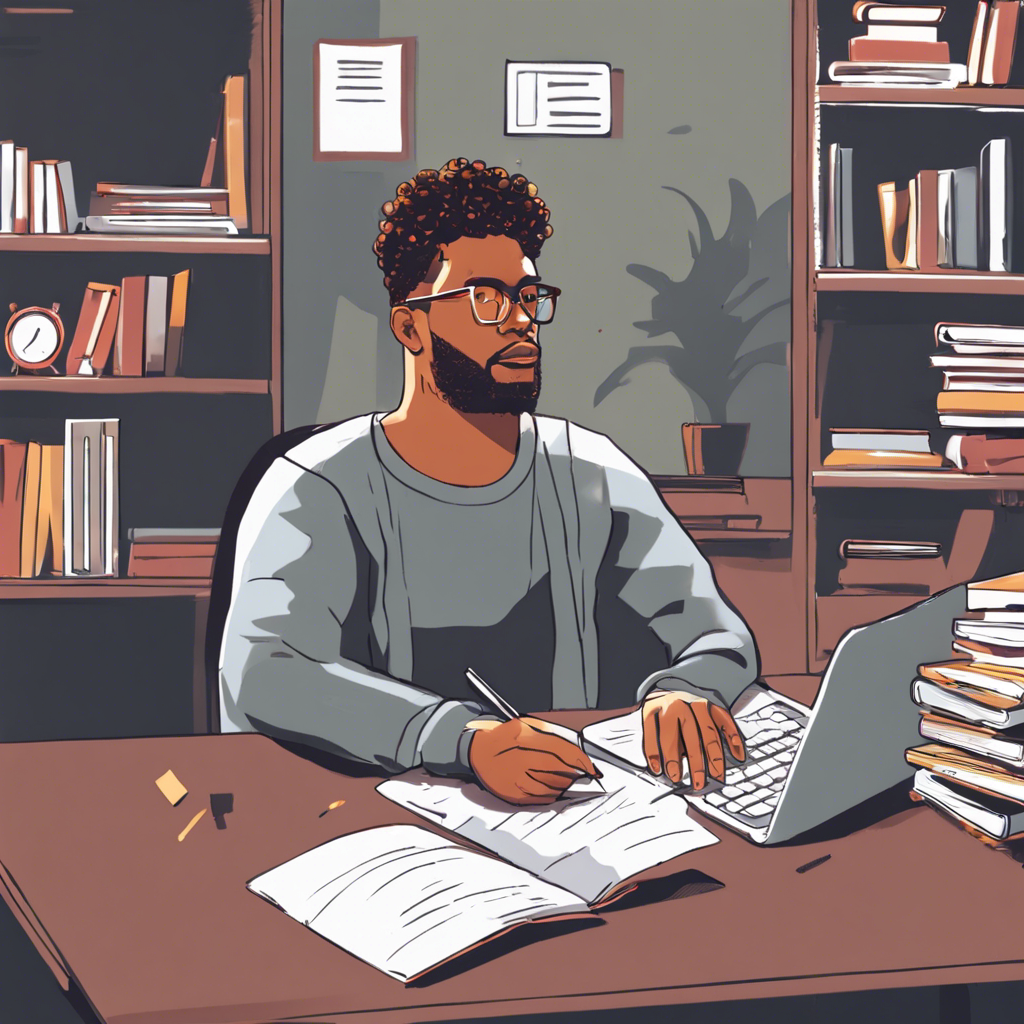

In [11]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="a ML student ready for the semester to be over",
    seed=121245125, # if provided, specifying a random seed makes results deterministic
    steps=50, # defaults to 30 if not specified
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

<a id='embeddings'></a>

<a href='#top'>Back to top</a>

## Embeddings
-----

Embeddings measure the relatedness of two objects. They're useful for search, clustering, anomaly detection, and more.

Embeddings are most frequently generated from ML models. The two embedding models we'll look at today are `text-embedding-ada-002`, used for text and code embeddings, and `CLIP` which lets you compare the similarity of text and images.

<a id='ada'></a>

<a href='#top'>Back to top</a>

### text-embedding-ada-002
-----

We have to use the OpenAI API for this. See [their announcement blog post](https://openai.com/blog/new-and-improved-embedding-model) for benchmarks and other details.

In [4]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai_client.embeddings.create(input = [text], model=model).data[0].embedding

emb = get_embedding("she sells seashells by the seashore")
print(emb)

[-0.010394117794930935, -0.0004441364435479045, 0.00994335301220417, -0.008557911962270737, -0.028504278510808945, 0.009472700767219067, -0.044837892055511475, 0.00027696380857378244, 0.008783294819295406, -0.02703266218304634, 0.018998432904481888, 0.027284560725092888, 0.014464263804256916, 0.003851392073556781, -0.006894058082252741, -0.01788477785885334, 0.02126551792025566, 0.01598891243338585, 0.004633602686226368, -0.045421235263347626, -0.019687838852405548, 0.023293960839509964, 0.015100638382136822, -0.007669639773666859, -0.01070567686110735, -0.01784500479698181, 0.010241653770208359, -0.0021510787773877382, 0.009141256101429462, -0.005266662687063217, -0.009194286540150642, 0.004885500762611628, -7.954682223498821e-05, -0.018879111856222153, -0.013973725028336048, 0.005700855515897274, -0.004888815339654684, 0.004285585135221481, -0.00737133901566267, 0.003443714464083314, -0.006207966711372137, -0.006502952892333269, -0.009698083624243736, 0.004414848517626524, -0.0085645

In [6]:
# Vectors of length 1536
print(len(emb))

1536


<a id='clip'></a>

<a href='#top'>Back to top</a>

### CLIP and OpenCLIP
-----

CLIP was developed by OpenAI. It can be downloaded from [their Git repo](https://github.com/openai/clip) and run locally. OpenCLIP is an open-source implementation of CLIP that you can [get here](https://github.com/mlfoundations/open_clip).

To keep things simple, we'll just demonstrate how to use CLIP.

![CLIP diagram](CLIP.png)

In [7]:
import torch # pip install torch torchvision
import clip  # pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git
from PIL import Image

/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 27.2MiB/s]


Label probs: [[0.99279356 0.00421071 0.00299575]]


<a id='databases'></a>

<a href='#top'>Back to top</a>

## Vector databases
-----

Vector databases provide a way to do vector search efficiently. This is useful in many ML applications, like similarity search and retrieval-augmented generation. There are many vector databases available, the most popular one being Pinecone. I'll also demonstrate a new SaaS-based vector database, called Astra DB, which is based on Apache Cassandra.

Instead of using a computationally expensive algorithm like kNN, vector databases typically use an approximation algorithm instead, called ANN (Approximate Nearest Neighbors). They also use many indexing tricks to support the scalability requirements of production data, both on the insert and query side.

<a id='pinecone'></a>

<a href='#top'>Back to top</a>

### Pinecone
-----

The easiest way to use Pinecone is via their SaaS, so to start you'll need to create a free account and generate an API token at https://www.pinecone.io.

In [6]:
import pinecone # pip install pinecone-client

pinecone_api_key = os.getenv('PINECONE_API_KEY')

if pinecone_api_key is None:
    raise ValueError("No API key found. Set the PINECONE_API_KEY environment variable.")

In [10]:
pinecone.init(api_key=pinecone_api_key,
              environment="gcp-starter")

pinecone.create_index("example-index", dimension=4)

In [11]:
index = pinecone.Index("example-index")

upsert_response = index.upsert(
    vectors=[
        ("vec1", [0.1, 0.2, 0.3, 0.4], {"genre": "drama"}),
        ("vec2", [0.2, 0.3, 0.4, 0.5], {"genre": "action"}),
    ],
    namespace="example-namespace"
)

In [14]:
query_response = index.query(
    namespace="example-namespace",
    top_k=10,
    include_values=True,
    include_metadata=True,
    vector=[0.1, 0.2, 0.3, 0.5],
    filter={
        "genre": {"$in": ["comedy", "documentary", "drama", "action"]}
    }
)
print(query_response)

{'matches': [{'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.993770719,
              'values': [0.1, 0.2, 0.3, 0.4]},
             {'id': 'vec2',
              'metadata': {'genre': 'action'},
              'score': 0.980573833,
              'values': [0.2, 0.3, 0.4, 0.5]}],
 'namespace': 'example-namespace'}


<a id='astra'></a>

<a href='#top'>Back to top</a>

### DataStax Astra DB
-----

Similarily, to get started with Astra DB, you'll need to create an account, a vector database, and an API token at https://astra.datastax.com. Make sure you copy the API endpoint as well for your database.

In [16]:
import os

from astrapy.db import AstraDB # pip install astrapy

# Initialization
db = AstraDB(
    token=os.environ["ASTRA_DB_APPLICATION_TOKEN"],
    api_endpoint=os.environ["ASTRA_DB_API_ENDPOINT"],
)

# Create collection
col = db.create_collection("vector_test", dimension=5, metric="cosine")

In [17]:
documents = [
    {
        "_id": "1",
        "text": "ChatGPT integrated sneakers that talk to you",
        "$vector": [0.1, 0.15, 0.3, 0.12, 0.05],
    },
    {
        "_id": "2",
        "text": "An AI quilt to help you sleep forever",
        "$vector": [0.45, 0.09, 0.01, 0.2, 0.11],
    },
    {
        "_id": "3",
        "text": "A deep learning display that controls your mood",
        "$vector": [0.1, 0.05, 0.08, 0.3, 0.6],
    },
]
res = col.insert_many(documents)

In [18]:
query = [0.15, 0.1, 0.1, 0.35, 0.55]
results = col.vector_find(query, limit=2, fields={"text", "$vector"})

for document in results:
    print(document)

{'_id': '3', 'text': 'A deep learning display that controls your mood', '$vector': [0.1, 0.05, 0.08, 0.3, 0.6], '$similarity': 0.99444735}
{'_id': '2', 'text': 'An AI quilt to help you sleep forever', '$vector': [0.45, 0.09, 0.01, 0.2, 0.11], '$similarity': 0.7967084}


<a id='rag'></a>

<a href='#top'>Back to top</a>

## Retrieval-Augmented Generation (RAG)
-----

LLMs have a tendency to hallucinate. Because they're just predicting the next word in a sequence, they can occasionally produce text that isn't factually true. Furthermore, the training data used for LLMs often lags real world events, so frequently an LLM isn't trained on the information you're trying to access.

RAG is a technique to address these issue. It uses embeddings and vector search to provide an LLM with ground truth in its context window. As the LLM generates text, it's able to use this context to generate text that's more likely to be accurate. Best of all, RAG does not require you to retrain the model, which is important since state of the art LLM models can take weeks or months to train.

There are many ways to wire up a RAG implementation, but we'll use OpenAI, LangChain, and Weaviate (another vector database) to demonstrate how to give a chatbot access to specific information to improve the accuracy of its responses.

This tutorial is adapted from https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2

![RAG diagram](rag.png)

To demonstrate the problem, let's ask a fairly innocuous question about a recent event which lacks the context necessary for ChatGPT to answer it.

In [42]:
print(query_gpt4("What did the president say about Justice Breyer?"))

As an AI, I don't have real-time access to news or current events, so I can't provide a live update on what the president might have said about Justice Stephen Breyer recently. As of my knowledge cutoff date in early 2023, there may be various statements made by the president in relation to Justice Breyer depending on the context and timing.

Justice Stephen Breyer was an Associate Justice of the Supreme Court of the United States, appointed in 1994 by President Bill Clinton. If you're referring to President Joe Biden, it's worth noting that when Justice Breyer announced his retirement on January 27, 2022, President Biden praised him for his nearly three decades of service on the Court and for his distinguished career in public service.

President Biden commended Justice Breyer's commitment to the rule of law, his advocacy for the importance of an independent judiciary, and his thoughtful judicial analysis. President Biden also noted that Justice Breyer's decisions demonstrated balance

Clearly we can do better by giving ChatGPT access to the specific context we want it to use as the basis of its answer.

The first thing we need to do is load in the data we want to use as extra context for the LLM.

In [21]:
# pip install langchain openai weaviate-client tiktoken

import requests
from langchain.document_loaders import TextLoader

url = "https://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/modules/state_of_the_union.txt"
res = requests.get(url)
with open("state_of_the_union.txt", "w") as f:
    f.write(res.text)

loader = TextLoader('./state_of_the_union.txt')
documents = loader.load()

In [23]:
print(documents)

[Document(page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. \n\nGroups of citize

Now, we can chunk the data. We do this to control the level of specificity of the context we provide to the LLM.

In [24]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

In [27]:
print(len(chunks))
print(chunks[0])
print(chunks[1])
print(chunks[2])
print(chunks[3])

90
page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny.' metadata={'source': './state_of_the_union.txt'}
page_content='Six days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their det

Next, we need to initialize our vector database, since this is what we'll use to run a vector search to get documents that are similar to the user's initial prompt.

The vector database takes as input the documents we chunked above, and the embeddings model we want to use (the default OpenAI embedding model).

In [29]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Weaviate
import weaviate
from weaviate.embedded import EmbeddedOptions

weaviate_client = weaviate.Client(
  embedded_options = EmbeddedOptions()
)

vectorstore = Weaviate.from_documents(
    client = weaviate_client,    
    documents = chunks,
    embedding = OpenAIEmbeddings(),
    by_text = False
)

embedded weaviate is already listening on port 8079


{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"langchain_980b0acbce3b4e9f81db54debf6345a0_QobAgqXWPoBD","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2023-12-10T10:02:36-08:00","took":57667}
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/langchain/embeddings/openai.py:501: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  response = response.dict()
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/pydantic/main.py:962: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


Now that all of the data is loaded and we've generated embeddings, we can prompt our LLM and go through the process of fetching context from the vector database.

First, we set the vector database as the retriever component, for supplying the LLM with additional context

In [30]:
retriever = vectorstore.as_retriever()

Next, we need to define the prompt that lets us insert additional context alongside the original user prompt.

In [31]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

print(prompt)

input_variables=['context', 'question'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. \nUse the following pieces of retrieved context to answer the question. \nIf you don't know the answer, just say that you don't know. \nUse three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:\n"))]


Finally, we can build a chain for the RAG pipeline. LangChain connects (chains) the retriever, the prompt template, and the LLM, so all we need to do is invoke it.

In [32]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()} 
    | prompt 
    | llm
    | StrOutputParser() 
)

query = "What did the president say about Justice Breyer"
rag_chain.invoke(query)

/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/langchain/embeddings/openai.py:501: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  response = response.dict()
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/pydantic/main.py:962: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)
/Users/djsauble/Downloads/e-82/.venv/lib/python3.9/site-packages/langchain/chat_models/openai.py:445: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 

"The president thanked Justice Breyer for his service and acknowledged his dedication to serving the country. The president also mentioned nominating Judge Ketanji Brown Jackson as a successor to continue Justice Breyer's legacy of excellence."

<a id='agents'></a>

<a href='#top'>Back to top</a>

## AI agents
-----

Agents extend the functionality of what LLMs can do. A typical LLM is capable of generating text based on its context and training data. In addition, an agent can choose to take action using tools that are made available to it.

The new [OpenAI Assistants API](https://platform.openai.com/docs/assistants/overview) provides the ability to write an agent that has access to OpenAI-hosted tools, like Code Interpreter and Knowledge Retrieval, or to custom tools that you define as functions.

Traditional LLMs are pretty bad at math because of how they work, but an agent can be instructed to write code to solve math problems and thus produce much better results than a typical LLM. Let's go through a simple example that demonstrates how this works.

First, let's show how even the latest GPT-4 Turbo fails to solve basic math problems correctly:

In [43]:
# Correct answer is 159.4915146
prompt = "5.423 * 29.4102 = ?"
print(query_gpt4(prompt))

To solve the multiplication of 5.423 and 29.4102, multiply these two numbers together:

5.423 * 29.4102 = 159.5142466


It's close but not quite right, and errors tend to compound, so as you get further into a math-focused chat session, the errors are going to get progressively worse.

To solve this, we can use the ChatGPT Assistants API to instruct GPT to use Code Interpreter to write and run Python code in a sandboxed execution environment to get more accurate answers to these sorts of questions.

In [46]:
assistant = openai_client.beta.assistants.create(
  instructions="You are a personal math tutor. When asked a math question, write and run code to answer the question.",
  model="gpt-4-1106-preview",
  tools=[{"type": "code_interpreter"}]
)

Next, create a thread with a message containing the math problem you want ChatGPT to solve

In [47]:
thread = openai_client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "5.423 * 29.4102 = ?"
    }
  ]
)

Finally, run the thread to get the agent's response to your prompt.

In [48]:
run = openai_client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [52]:
messages = openai_client.beta.threads.messages.list(thread_id=thread.id)

In [55]:
messages.data[0].content[0].text.value

'The product of 5.423 and 29.4102 is approximately 159.4915146.'

And this is exactly the correct answer! To recap:

* Original prompt: 5.423 * 29.4102 = ?
* Correct answer: 159.4915146
* Answer w/o agent: 159.5142466 (wrong)
* Answer w/ agent: 159.4915146 (right!)